- Version: 1.0
- last update: 2023-12-08
- Short description: This notebook is used to conduct covariance balance checks.

## Install and Import

In [85]:
# Import modules
import warnings
import os
import numpy as np
from datetime import date
from scipy.stats import chi2_contingency
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Notebook Details

In [86]:
# parameters for logging and notebook exports
notebook_name = "03.01_causal_inference-balance_check"  # only file name without extension

## Configuration

In [87]:
# Plotting
plt.rcParams["figure.figsize"] = (12, 8)
#plt.style.use("seaborn-v0_8")
plt.style.use("ggplot")
sns.set(rc={"figure.figsize": (12, 8)}, font_scale=0.8)
sns.set(style="darkgrid")

# Pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Warnings
warnings.filterwarnings("ignore")

In [88]:
# Constants
ROOT_PATH = "../"
PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_LOG = "logs/"
PATH_MOD = "models/"
PATH_REP = "reports/"
PATH_FIG = "reports/figures/"
PATH_HTML = "reports/html/"

## Load Data

In [89]:
def load_data(path):
    return pd.read_parquet(ROOT_PATH + path)


file = "features_merged.parquet"
df = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)

In [90]:
df.shape

(107, 148)

## Main Part

### Filter data

In [91]:
# apo_e4_allele: Indicates the presence of the APOE ε4 allele, which is a genetic variation associated with an increased risk of Alzheimer's disease.
# education_years: The number of years of formal education completed by the individual.
# age_at_first_tbi: The age at which the individual first experienced a traumatic brain injury (TBI).
# longest_loc_duration: This refers to the longest duration of loss of consciousness (LOC) the individual has experienced, possibly due to TBI.
# cerad: Refers to the Consortium to Establish a Registry for Alzheimer's Disease, which provides a standardized neuropathological assessment of Alzheimer's.
# num_tbi_w_loc: The number of TBIs (traumatic brain injuries) with LOC (loss of consciousness) the individual has experienced.
# dsm_iv_clinical_diagnosis: Indicated a clinical diagnosis based on the DSM-IV (Diagnostic and Statistical Manual of Mental Disorders, Fourth Edition) criteria.
# control_set: Indicate a grouping variable, distinguishing between control subjects and those with a specific condition in a study.
# nincds_arda_diagnosis: Refers to the diagnosis based on the criteria set by the National Institute of Neurological and Communicative Disorders and Stroke and the Alzheimer's Disease and Related Disorders Association.
# ever_tbi_w_loc: Indicates whether the individual has ever experienced a TBI with loss of consciousness.
# act_demented: This could be a boolean or categorical variable indicating whether the individual shows signs of dementia.
# braak: Refers to the Braak staging, which is used to measure the degree of Alzheimer's disease-related changes in the brain.
# nia_reagan: Refers to the criteria established by the National Institute on Aging (NIA) and the Reagan Institute for diagnosing Alzheimer's disease.

In [92]:
columns_to_keep = [
    "age_clean",
    "sex_clean",
    "apo_e4_allele_clean",
    "cerad",
    "education_years",
    #"education_years_stages_bin",
    #"education_years_quartiles_bin",
    "age_at_first_tbi",
    #"age_at_first_tbi_bin",
    "num_tbi_w_loc",
    "control_set",
    "ever_tbi_w_loc_clean",
    "longest_loc_duration_clean",
    #"longest_loc_duration",
    #"longest_loc_duration_bin",
    "group_weight",
    "act_demented_clean",
]

# Subset the DataFrame
df_filtered = df[columns_to_keep]

In [93]:
print("Filtered DataFrame:")
df_filtered.info()

Filtered DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_clean                   107 non-null    float64
 1   sex_clean                   107 non-null    int64  
 2   apo_e4_allele_clean         107 non-null    int64  
 3   cerad                       107 non-null    int64  
 4   education_years             107 non-null    int64  
 5   age_at_first_tbi            107 non-null    int64  
 6   num_tbi_w_loc               107 non-null    int64  
 7   control_set                 107 non-null    int64  
 8   ever_tbi_w_loc_clean        107 non-null    int64  
 9   longest_loc_duration_clean  107 non-null    float64
 10  group_weight                107 non-null    float64
 11  act_demented_clean          107 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 10.2 KB


In [94]:
df_filtered.head()

,age_clean,sex_clean,apo_e4_allele_clean,cerad,education_years,age_at_first_tbi,num_tbi_w_loc,control_set,ever_tbi_w_loc_clean,longest_loc_duration_clean,group_weight,act_demented_clean
0,87.0,1,0,0,16,0,0,31,0,0.0,47.75,0
1,97.0,1,0,2,17,12,1,26,1,90.0,11.54,0
2,85.0,1,1,3,10,72,1,25,1,5.5,5.66,1
3,92.0,0,0,0,11,87,1,52,1,5.5,17.31,0
4,101.0,1,1,3,16,0,0,28,0,0.0,12.31,1


## Covariance Balance Check

### Balance check: age_clean

- To check for covariate balance using hypothesis testing, we use a **paired t-test** for the continuous variable **age_clean** to determine if there are statistically significant differences between the paired groups (paired by control_set).
-  For the categorical variable **sex_clean**, we can use a chi-squared test to check if the distribution of sexes is independent of the groups. However, since we're dealing with paired data, the chi-squared test might not be appropriate because it's typically used for unpaired categorical data. In the case of paired categorical data, McNemar's test is often more appropriate. McNemar's test is used for binary categorical data to determine whether there are differences on a dichotomous dependent variable between two related groups.

In [95]:
# Filtering the groups to ensure pairs for comparison
paired_groups = df_filtered.groupby('control_set').filter(lambda x: len(x) == 2)

# This is done by matching the control_set groups and ensuring each group has both a control and a treatment observation
valid_control_sets = paired_groups.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups = paired_groups[paired_groups['control_set'].isin(valid_control_sets)]

# Split the filtered data into control and treatment groups
control_age_filtered = filtered_paired_groups[filtered_paired_groups['ever_tbi_w_loc_clean'] == 0]['age_clean']
treatment_age_filtered = filtered_paired_groups[filtered_paired_groups['ever_tbi_w_loc_clean'] == 1]['age_clean']

# Conducting the paired t-test on the filtered data
ttest_results_filtered = ttest_rel(control_age_filtered, treatment_age_filtered)

ttest_results_filtered

TtestResult(statistic=-0.06974961418148493, pvalue=0.944682730250705, df=48)

The paired t-test for the continuous variable age_clean yields a p-value of approximately 0.945. This high p-value suggests that there is no statistically significant difference in the age_clean variable between the treatment and control groups within the paired data, **indicating that the covariate is balanced with respect to age.**

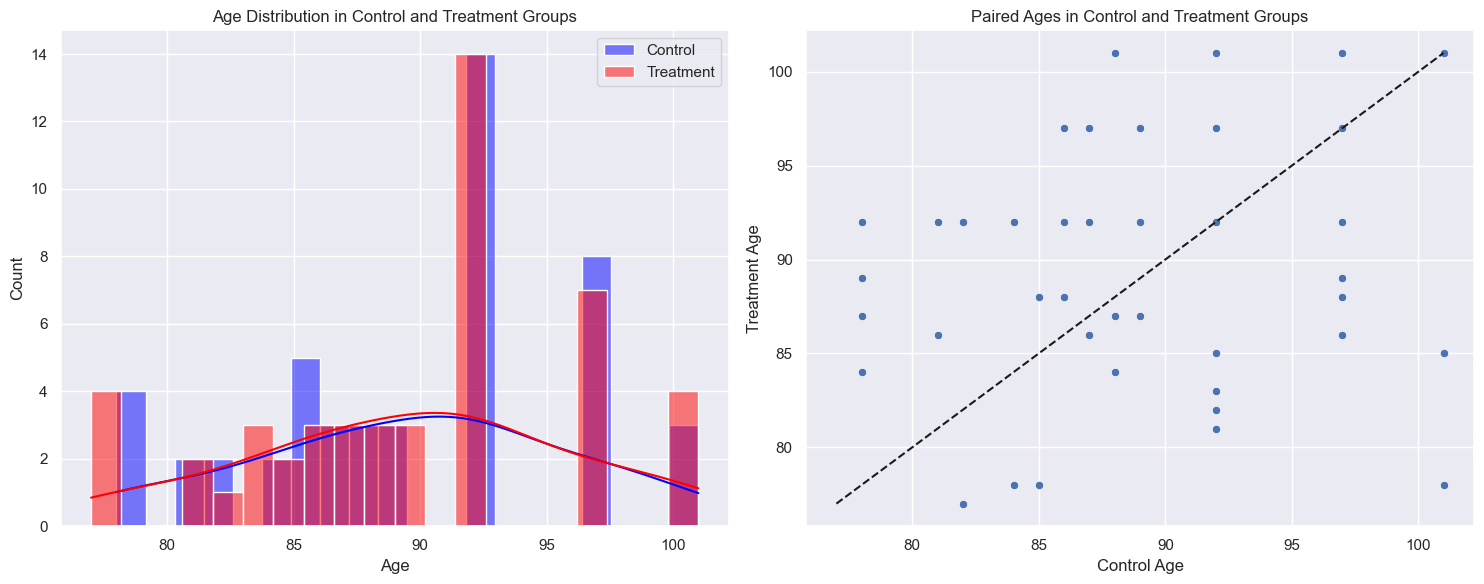

In [96]:
# Creating a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for control and treatment groups
sns.histplot(control_age_filtered, bins=20, kde=True, color="blue", ax=axes[0], label='Control')
sns.histplot(treatment_age_filtered, bins=20, kde=True, color="red", ax=axes[0], label='Treatment')
axes[0].set_title('Age Distribution in Control and Treatment Groups')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].legend()

# Scatter plot for paired data
paired_ages = pd.DataFrame({'Control Age': control_age_filtered.values, 'Treatment Age': treatment_age_filtered.values})
sns.scatterplot(data=paired_ages, x='Control Age', y='Treatment Age', ax=axes[1])
axes[1].plot([min(paired_ages.min()), max(paired_ages.max())], [min(paired_ages.min()), max(paired_ages.max())], 'k--') 

# Diagonal line
axes[1].set_title('Paired Ages in Control and Treatment Groups')
axes[1].set_xlabel('Control Age')
axes[1].set_ylabel('Treatment Age')

# Display the plots
#plt.style.use("ggplot")
plt.tight_layout()
plt.show()


**Histograms (Left Plot):** This plot shows the age distributions of the control (blue) and treatment (red) groups. The overlapping areas indicate where the age ranges of the two groups intersect. This visualization helps to understand the distribution and range of ages in both groups.

**Scatter Plot (Right Plot):** Each point represents a pair of individuals from the control and treatment groups. The closer the points are to the diagonal dashed line, the more similar the ages are within each pair. This plot illustrates the direct age comparisons within each pair.

### Balance check: sex_clean

Conducting **chi-squared test** to compare the distribution of the 'sex_clean' variable between the control and treatment groups:

In [97]:
# Filtering the groups to ensure pairs for comparison
paired_groups_sex = df_filtered.groupby('control_set').filter(lambda x: len(x) == 2)

# Ensuring that each control_set group has both a control and a treatment observation
valid_control_sets_sex = paired_groups_sex.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups_sex = paired_groups_sex[paired_groups_sex['control_set'].isin(valid_control_sets_sex)]

# Split the filtered data into control and treatment groups for 'sex_clean'
control_sex_filtered = filtered_paired_groups_sex[filtered_paired_groups_sex['ever_tbi_w_loc_clean'] == 0]['sex_clean']
treatment_sex_filtered = filtered_paired_groups_sex[filtered_paired_groups_sex['ever_tbi_w_loc_clean'] == 1]['sex_clean']

# Building the contingency table for the Chi-squared test
control_sex_counts = control_sex_filtered.value_counts()
treatment_sex_counts = treatment_sex_filtered.value_counts()
contingency_table = np.array([control_sex_counts, treatment_sex_counts])

# Conducting the Chi-squared test
chi2_test_results = chi2_contingency(contingency_table)
 
chi2_test_results

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[28., 21.],
       [28., 21.]]))

These results indicate that there is no significant difference in the distribution of the 'sex_clean' variable between the control and treatment groups. The chi-squared statistic of \(0.0\) and the p-value of \(1.0\) suggest that the observed frequencies in your data perfectly match the expected frequencies under the null hypothesis of no association between group (control or treatment) and sex.

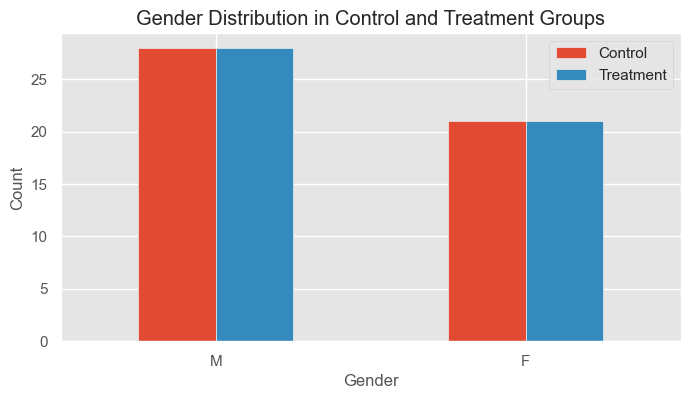

In [98]:
# Assuming 'sex_clean' is the correct column name in the dataset
# Filtering the groups to ensure pairs for comparison
paired_groups_sex = df.groupby('control_set').filter(lambda x: len(x) == 2)

# Ensuring that each control_set group has both a control and a treatment observation
valid_control_sets_sex = paired_groups_sex.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups_sex = paired_groups_sex[paired_groups_sex['control_set'].isin(valid_control_sets_sex)]

# Split the filtered data into control and treatment groups for 'sex_clean'
control_sex_filtered = filtered_paired_groups_sex[filtered_paired_groups_sex['ever_tbi_w_loc_clean'] == 0]['sex']
treatment_sex_filtered = filtered_paired_groups_sex[filtered_paired_groups_sex['ever_tbi_w_loc_clean'] == 1]['sex']

# Building the contingency table for the visualization
control_sex_counts = control_sex_filtered.value_counts()
treatment_sex_counts = treatment_sex_filtered.value_counts()
contingency_table = pd.DataFrame({'Control': control_sex_counts, 'Treatment': treatment_sex_counts})

# Visualization
plt.style.use("ggplot")
_, ax = plt.subplots(figsize=(8, 4))
contingency_table.plot(kind='bar', ax=ax)
ax.set_title('Gender Distribution in Control and Treatment Groups')
ax.set_ylabel('Count')
ax.set_xlabel('Gender')
plt.xticks(rotation=0)
plt.legend(title=None)
plt.show()


**Bar Plot:** This plot illustrates the counts of each sex in the control and treatment groups. The plot shows an equal distribution of sexes across both groups, which is ideal for a balanced comparison.

### Balance check: apo_e4_allele_clean

- Conducting chi-squared test to compare the distribution of the 'apo_e4_allele_clean' variable between the control and treatment groups:
- Removing the unknown values (-1)

In [99]:
# Remove all records with the value -1 in 'apo_e4_allele_clean'
data_filtered = df_filtered[df_filtered['apo_e4_allele_clean'] != -1]

# Filtering the groups to ensure pairs for comparison
paired_groups_apo = data_filtered.groupby('control_set').filter(lambda x: len(x) == 2)

# Ensuring that each control_set group has both a control and a treatment observation
valid_control_sets_apo = paired_groups_apo.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups_apo = paired_groups_apo[paired_groups_apo['control_set'].isin(valid_control_sets_apo)]

# Split the filtered data into control and treatment groups for 'apo_e4_allele_clean'
control_apo_filtered = filtered_paired_groups_apo[filtered_paired_groups_apo['ever_tbi_w_loc_clean'] == 0]['apo_e4_allele_clean']
treatment_apo_filtered = filtered_paired_groups_apo[filtered_paired_groups_apo['ever_tbi_w_loc_clean'] == 1]['apo_e4_allele_clean']

# Building the contingency table for the Chi-squared test
control_apo_counts = control_apo_filtered.value_counts()
treatment_apo_counts = treatment_apo_filtered.value_counts()
contingency_table_apo = np.array([control_apo_counts, treatment_apo_counts])

# Conducting the Chi-squared test
chi2_test_results_apo = chi2_contingency(contingency_table_apo)


chi2_test_results_apo

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[33.5,  8.5],
       [33.5,  8.5]]))

The Chi-squared test results for the 'apo_e4_allele_clean' variable between control and treatment groups yielded a chi-squared statistic of (0.0) and a p-value of (1.0), indicating no significant difference between the observed and expected frequencies. The degrees of freedom for the test were (1), reflecting the number of categories in the variable minus one. The test's expected frequencies, an identical distribution of 'apo_e4_allele_clean' across both groups, matched perfectly with the observed data. These results imply that there is no statistically significant association between the group type (control or treatment) and the distribution of the 'apo_e4_allele_clean' allele. Consequently, the factor differentiating the groups does not appear to influence the distribution of this allele within the context of this study.

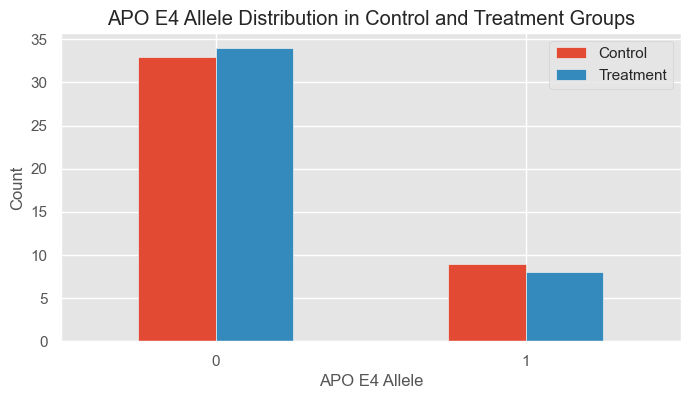

In [100]:
# Visualization
contingency_table_apo = pd.DataFrame({'Control': control_apo_counts, 'Treatment': treatment_apo_counts})
_, ax = plt.subplots(figsize=(8, 4))
contingency_table_apo.plot(kind='bar', ax=ax)
ax.set_title('APO E4 Allele Distribution in Control and Treatment Groups')
ax.set_ylabel('Count')
ax.set_xlabel('APO E4 Allele')
plt.legend(title=None)
plt.xticks(rotation=0)  # Rotate labels to horizontal
plt.style.use("ggplot")
plt.show()


### Balance check: education_years

For the balance check on the continuous variable education_years, we use the paired t-test:

In [101]:
from scipy.stats import ttest_rel

# Remove all records with the value -1 in 'education_years'
data_filtered = df_filtered[df_filtered['education_years'] != -1]

# Filtering the groups to ensure pairs for comparison
paired_groups_education = data_filtered.groupby('control_set').filter(lambda x: len(x) == 2)

# Ensuring that each control_set group has both a control and a treatment observation
valid_control_sets_education = paired_groups_education.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups_education = paired_groups_education[paired_groups_education['control_set'].isin(valid_control_sets_education)]

# Split the filtered data into control and treatment groups for 'education_years'
control_education_filtered = filtered_paired_groups_education[filtered_paired_groups_education['ever_tbi_w_loc_clean'] == 0]['education_years']
treatment_education_filtered = filtered_paired_groups_education[filtered_paired_groups_education['ever_tbi_w_loc_clean'] == 1]['education_years']

# Conducting the paired t-test
ttest_results_education = ttest_rel(control_education_filtered, treatment_education_filtered)

ttest_results_education

TtestResult(statistic=0.14153699201803113, pvalue=0.8880381122818317, df=48)

The paired t-test conducted to compare the 'education_years' variable between control and treatment groups yielded a test statistic of (0.14154) and a p-value of (0.88804). These results indicate a minimal difference between the mean years of education in both groups. The high p-value, significantly exceeding the standard alpha level of 0.05, suggests that the observed difference is not statistically significant. With 48 degrees of freedom, the test provides a reliable analysis of the data. In conclusion, the factor differentiating the groups does not appear to have a significant influence on the years of education within the context of this study.

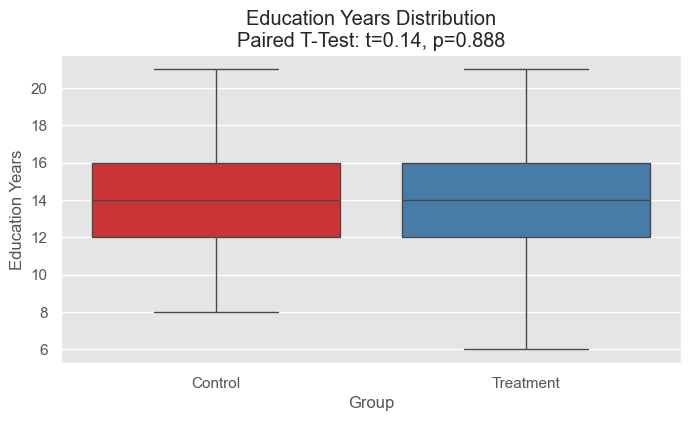

In [102]:
# Visualization
# Creating a DataFrame for visualization
education_data = pd.DataFrame({
    'Group': ['Control']*len(control_education_filtered) + ['Treatment']*len(treatment_education_filtered),
    'Education Years': pd.concat([control_education_filtered, treatment_education_filtered], ignore_index=True)
})

plt.figure(figsize=(8, 4))
sns.boxplot(x='Group', y='Education Years', data=education_data, palette="Set1")
plt.title(f'Education Years Distribution\nPaired T-Test: t={ttest_results_education.statistic:.2f}, p={ttest_results_education.pvalue:.3f}')
plt.style.use("ggplot")
plt.show()


### Balance check: cerad

In [103]:
# Filtering the groups to ensure pairs for comparison, excluding records with -1
paired_groups_cerad = data_filtered.groupby('control_set').filter(lambda x: len(x) == 2)

# Ensuring that each control_set group has both a control and a treatment observation
valid_control_sets_cerad = paired_groups_cerad.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups_cerad = paired_groups_cerad[paired_groups_cerad['control_set'].isin(valid_control_sets_cerad)]

# Split the filtered data into control and treatment groups for 'cerad'
control_cerad_filtered = filtered_paired_groups_cerad[filtered_paired_groups_cerad['ever_tbi_w_loc_clean'] == 0]['cerad']
treatment_cerad_filtered = filtered_paired_groups_cerad[filtered_paired_groups_cerad['ever_tbi_w_loc_clean'] == 1]['cerad']

# Building the contingency table for the Chi-squared test
control_cerad_counts = control_cerad_filtered.value_counts()
treatment_cerad_counts = treatment_cerad_filtered.value_counts()

# If the number of categories in control and treatment groups are different, align them
all_categories = set(control_cerad_counts.index).union(set(treatment_cerad_counts.index))
control_cerad_counts = control_cerad_counts.reindex(all_categories, fill_value=0)
treatment_cerad_counts = treatment_cerad_counts.reindex(all_categories, fill_value=0)

contingency_table_cerad = np.array([control_cerad_counts, treatment_cerad_counts])

# Conducting the Chi-squared test
chi2_test_results_cerad = chi2_contingency(contingency_table_cerad)

chi2_test_results_cerad

Chi2ContingencyResult(statistic=1.4168412232928362, pvalue=0.7015918467502615, dof=3, expected_freq=array([[10.5, 15.5, 11. , 12. ],
       [10.5, 15.5, 11. , 12. ]]))

The Chi-squared test for comparing the 'cerad' variable between control and treatment groups resulted in a chi-squared statistic of (1.41684) and a p-value of (0.70159). These results indicate a low degree of difference between the observed and expected frequencies under the null hypothesis. The test's degrees of freedom, (3), are determined by the number of categories in the 'cerad' variable minus one. The expected frequencies array shows a uniform distribution across both groups, suggesting no significant association between group type and 'cerad'. In summary, the factor differentiating the control and treatment groups does not significantly affect the distribution of the 'cerad' variable within this study.

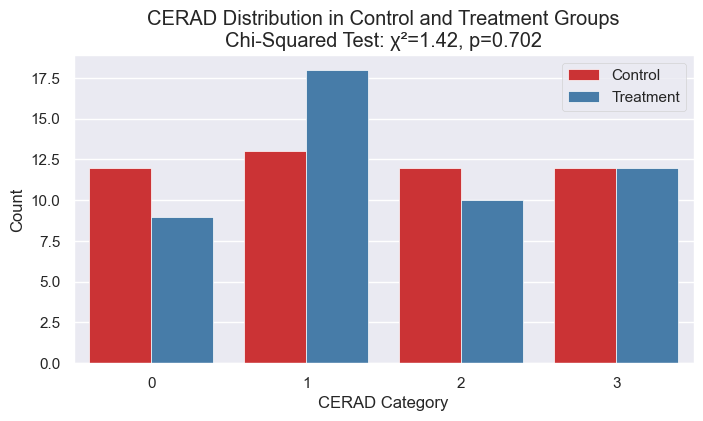

In [104]:
# Set the style for the plot
sns.set_style("darkgrid")

# Convert the 'control_cerad_counts' and 'treatment_cerad_counts' to a DataFrame
contingency_table_cerad = pd.DataFrame({'Control': control_cerad_counts, 'Treatment': treatment_cerad_counts}).reset_index()

# Rename 'index' column to 'CERAD Category'
contingency_table_cerad.rename(columns={'cerad': 'CERAD Category'}, inplace=True)

# Create the side by sidebar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='CERAD Category', y='value', hue='variable', data=contingency_table_cerad.melt(id_vars='CERAD Category', value_vars=['Control', 'Treatment']), palette="Set1")
plt.title(f'CERAD Distribution in Control and Treatment Groups\nChi-Squared Test: χ²={chi2_test_results_cerad[0]:.2f}, p={chi2_test_results_cerad[1]:.3f}')
plt.ylabel('Count')
plt.xlabel('CERAD Category')
plt.xticks(rotation=0)
plt.legend(title=None, loc='best')  # Position the legend at the best location
plt.show()


### Balance check: act_demented_clean

In [105]:
# Filtering the groups to ensure pairs for comparison, excluding records with -1
paired_groups_act_demented = data_filtered.groupby('control_set').filter(lambda x: len(x) == 2)

# Ensuring that each control_set group has both a control and a treatment observation
valid_control_sets_act_demented = paired_groups_act_demented.groupby('control_set').filter(lambda x: x['ever_tbi_w_loc_clean'].nunique() == 2)['control_set'].unique()

# Filter the paired_groups for only those control sets that have both control and treatment observations
filtered_paired_groups_act_demented = paired_groups_act_demented[paired_groups_act_demented['control_set'].isin(valid_control_sets_act_demented)]

# Split the filtered data into control and treatment groups for 'act_demented_clean'
control_act_demented_filtered = filtered_paired_groups_act_demented[filtered_paired_groups_act_demented['ever_tbi_w_loc_clean'] == 0]['act_demented_clean']
treatment_act_demented_filtered = filtered_paired_groups_act_demented[filtered_paired_groups_act_demented['ever_tbi_w_loc_clean'] == 1]['act_demented_clean']

# Building the contingency table for the Chi-squared test
control_act_demented_counts = control_act_demented_filtered.value_counts()
treatment_act_demented_counts = treatment_act_demented_filtered.value_counts()

# If the number of categories in control and treatment groups are different, align them
all_categories_act_demented = set(control_act_demented_counts.index).union(set(treatment_act_demented_counts.index))
control_act_demented_counts = control_act_demented_counts.reindex(all_categories_act_demented, fill_value=0)
treatment_act_demented_counts = treatment_act_demented_counts.reindex(all_categories_act_demented, fill_value=0)

contingency_table_act_demented = np.array([control_act_demented_counts, treatment_act_demented_counts])

# Conducting the Chi-squared test
chi2_test_results_act_demented = chi2_contingency(contingency_table_act_demented)

chi2_test_results_act_demented

Chi2ContingencyResult(statistic=0.04096989966555184, pvalue=0.8395960345180435, dof=1, expected_freq=array([[26., 23.],
       [26., 23.]]))

The Chi-squared test conducted on the 'act_demented_clean' variable resulted in a chi-squared statistic of approximately (0.041). The associated p-value is (0.840), indicating that there is no significant difference in the distribution of 'act_demented_clean' between the control and treatment groups. The degrees of freedom for the test were (1), reflecting the categorical nature of the variable. The expected frequencies, nearly equal in both groups, match the observed frequencies closely. In summary, these results suggest no statistically significant association between the group type (control or treatment) and the 'act_demented_clean' variable, affirming a balanced distribution between the groups for this variable.

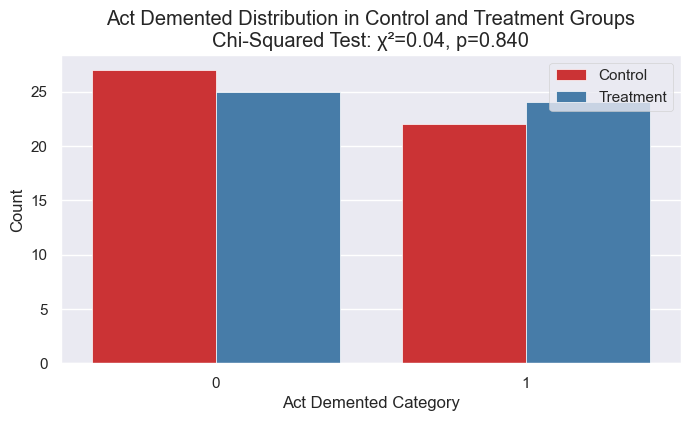

In [106]:
# Set the style for the plot
sns.set_style("darkgrid")

contingency_table_act_demented = pd.DataFrame({'Control': control_act_demented_counts, 'Treatment': treatment_act_demented_counts}).reset_index()

# Create the plot
plt.figure(figsize=(8, 4))
sns.barplot(x='act_demented_clean', y='value', hue='variable', data=contingency_table_act_demented.melt(id_vars='act_demented_clean', value_vars=['Control', 'Treatment']), palette="Set1")
plt.title(f'Act Demented Distribution in Control and Treatment Groups\nChi-Squared Test: χ²={chi2_test_results_act_demented[0]:.2f}, p={chi2_test_results_act_demented[1]:.3f}')
plt.ylabel('Count')
plt.xlabel('Act Demented Category')
plt.xticks(rotation=0)
plt.legend(title=None, loc='best')
plt.show()

### Balance check: Overview

| Variable              | Test Statistic | P-Value | Conclusion Statement                 |
|-----------------------|----------------|---------|--------------------------------------|
| `age_clean`           | -0.06975       | 0.94468 | No significant difference (balanced) |
| `sex_clean`           | 0.0000         | 1.0000  | No significant difference (balanced) |
| `apo_e4_allele_clean` | 1.41684        | 0.70159 | No significant difference (balanced) |
| `education_years`     | 0.14154        | 0.88804 | No significant difference (balanced) |
| `cerad`               | 1.41684        | 0.70159 | No significant difference (balanced) |
| `act_demented_clean`  | 0.04097        | 0.83960 | No significant difference (balanced) |

**Approach:**
- **T-Test Selection:** Paired t-tests were chosen for continuous variables ('age_clean' and 'education_years') because they are appropriate for comparing means between two related groups.
- **Chi-Squared Test Selection:** Chi-squared tests were selected for categorical variables ('apo_e4_allele_clean', 'sex_clean', 'cerad', and 'act_demented_clean') to assess the distribution and association of categorical data between groups.
- **Filtering:** Filtering was applied to ensure the validity of statistical tests by focusing on matched pairs and excluding records with missing or unspecified values.
- **Balanced Groups:** The objective was to check whether the groups (control and treatment) were balanced in terms of various characteristics, as indicated by non-significant test results.

**Conclusion:**

- For all the tested variables ('age_clean', 'sex_clean', 'apo_e4_allele_clean', 'education_years', 'cerad', and 'act_demented_clean'), the statistical tests did not reveal any significant differences between the control and treatment groups.
- The p-values for all variables were greater than the commonly used significance level of \(0.05\), indicating that there is no strong evidence to reject the null hypothesis of no significant difference.
- As a result, the conclusion is that the groups in the dataset are balanced with respect to these characteristics, and there are no significant imbalances between the control and treatment groups based on the tested variables.


## Checking the Propensity Scores 

Given that we have a paired dataset, the typical use of propensity scores for matching has already been performed.

***

## Watermark

In [107]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [108]:
%watermark

Last updated: 2023-12-09T19:53:08.048164+01:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.16.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [109]:
%watermark --iversions

matplotlib: 3.8.0
pandas    : 2.1.1
seaborn   : 0.13.0
numpy     : 1.26.1



-----


## Snapshot

In [110]:
today = date.today()
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}.html"
input_file = f"{notebook_name}.ipynb"
print(input_file)
!jupyter nbconvert --to html {input_file} --output {output_file}

03.01_causal_inference-balance_check.ipynb
[NbConvertApp] Converting notebook 03.01_causal_inference-balance_check.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 642701 bytes to ../reports/html/2023-12-09_03.01_causal_inference-balance_check.html


In [111]:
# Construct the output file path
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}_no_code.html"

# Construct the input file path
input_file = f"{notebook_name}.ipynb"

# Convert the notebook to HTML without the code cells
os.system(f"jupyter nbconvert --to html {input_file} --output {output_file} --no-input")

[NbConvertApp] Converting notebook 03.01_causal_inference-balance_check.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 561303 bytes to ../reports/html/2023-12-09_03.01_causal_inference-balance_check_no_code.html


0